In [15]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import os
import pickle
import requests
import bs4 as bs
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import io
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib import style

In [2]:
def save_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0'}
    resp = requests.get(url, headers=headers)
    df = pd.read_html(io.StringIO(resp.text))[0]
    tickers = df['Symbol'].tolist()
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    print(f"Success: {len(tickers)} tickers saved.")
    return tickers
save_sp500_tickers()

Success: 503 tickers saved.


['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APP',
 'APTV',
 'ACGL',
 'ADM',
 'ARES',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'XYZ',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'CCL',
 'CARR',
 'CVNA',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'COIN',
 'CL',
 'CMCSA',
 'FIX',
 'CAG',
 'COP',
 'ED'

In [3]:
def get_data():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', headers={'User-Agent': 'Mozilla/5.0'})
    df = pd.read_html(io.StringIO(resp.text))[0]
    tickers = [t.replace('.', '-') for t in df['Symbol']]
    if not os.path.exists('stock_dfs'): os.makedirs('stock_dfs')
    for t in tickers:
        path = f'stock_dfs/{t}.csv'
        if not os.path.exists(path):
            print(f"Downloading {t}")
            data = yf.download(t, start="2015-01-01", end="2026-01-10")
            if not data.empty: data.to_csv(path)
get_data()

In [4]:
import pickle, pandas as pd, os
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    for count, ticker in enumerate(tickers):
        f_ticker = ticker.replace('.', '-')
        path = 'stock_dfs/{}.csv'.format(f_ticker)
        if os.path.exists(path):
            df = pd.read_csv(path, index_col=0)
            new_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
            df.rename(columns={new_col: ticker}, inplace=True)
            df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1, inplace=True, errors='ignore')
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')
        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

compile_data()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                          MMM                 AOS                 ABT  \
Price                                                                   
2015-01-02   96.1085433959961   23.47296142578125    36.2351188659668   
2015-01-05   93.9410629272461  23.062253952026367   36.24319076538086   
2015-01-06  92.93927764892578  22.873674392700195   35.83161926269531   
2015-01-07  93.61299896240234  23.041297912597656  36.122127532958984   
2015-01-08  95.85664367675781  23.640602111816406   36.86459732055664   

                          ABBV                ACN               ADBE  \
Price                                                                  
2015-01-02  41.755462646484375  74.25260162353516  72.33999633789062   
2015-01-05  40.969669342041016   72.9989242553711   71.9800033569336   
2015-01

In [5]:
import pandas as pd
import numpy as np

def create_correlation_table():
    # 1. Load the data
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    
    # 2. CLEANING: Convert everything to numeric, turn errors (strings) into NaN
    # This fixes the "unsupported operand type: str and float" error
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # 3. Handle missing values 
    # pct_change needs continuous data. We fill missing values with the last known price.
    df.ffill(inplace=True)
    
    # 4. Calculate daily percentage change
    # We set fill_method=None to avoid the FutureWarning
    df_returns = df.pct_change(fill_method=None)
    
    # 5. Create the correlation matrix
    df_corr = df_returns.corr()
    
    # 6. Save the table
    df_corr.to_csv('sp500_correlation_table.csv')
    
    print("Correlation table saved successfully.")
    print("\nShape of Correlation Table:", df_corr.shape)
    print(df_corr.iloc[:5, :5]) # Show a small 5x5 slice

create_correlation_table()

C:\Users\Hp\AppData\Local\Temp\ipykernel_14004\3839379799.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,2

Correlation table saved successfully.

Shape of Correlation Table: (503, 503)
           MMM       AOS       ABT      ABBV       ACN
MMM   1.000000  0.504614  0.386789  0.307915  0.474042
AOS   0.504614  1.000000  0.354828  0.270686  0.454142
ABT   0.386789  0.354828  1.000000  0.428826  0.495557
ABBV  0.307915  0.270686  0.428826  1.000000  0.322958
ACN   0.474042  0.454142  0.495557  0.322958  1.000000


Plot saved as 'sp500_correlation_heatmap.png'


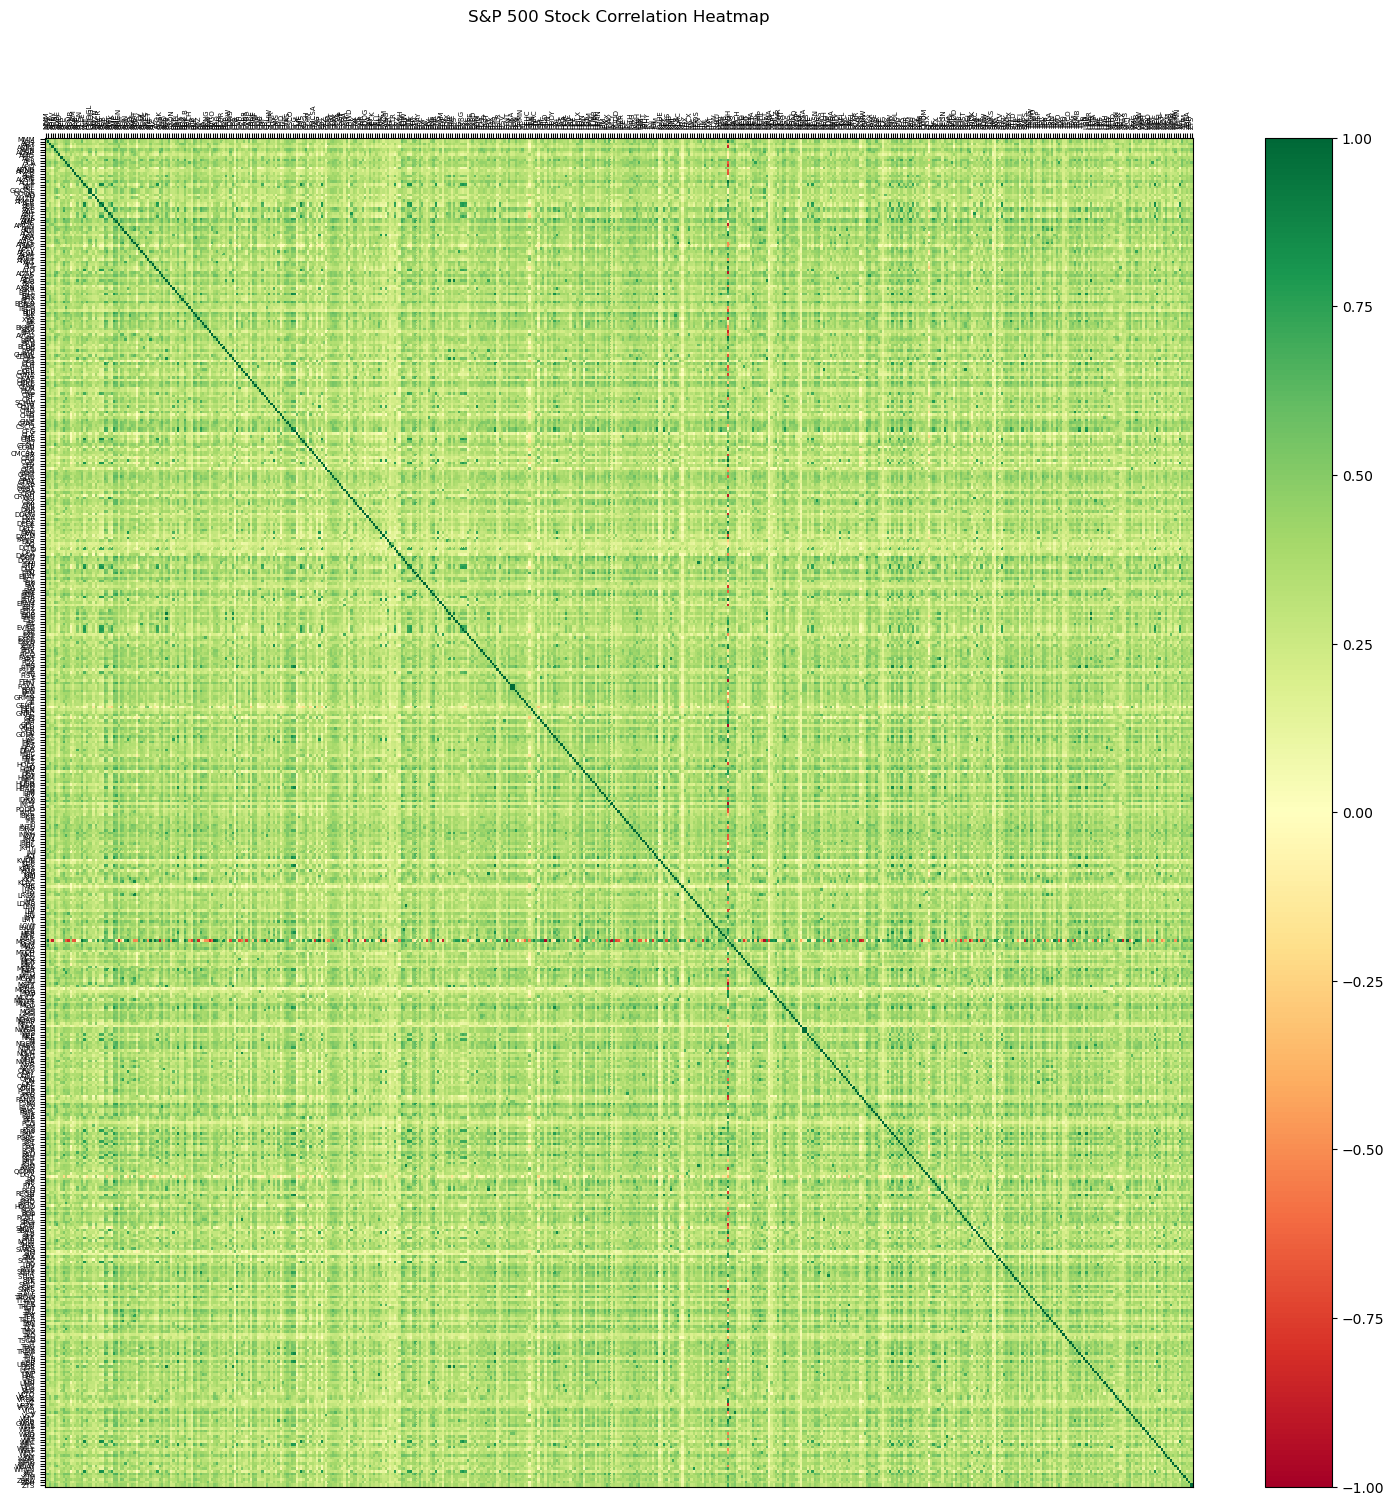

In [13]:
def visualize_data():
    df_corr = pd.read_csv('sp500_correlation_table.csv', index_col=0)
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(df_corr, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(len(df_corr.columns)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(df_corr.index)) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(df_corr.columns, fontsize=5)
    ax.set_yticklabels(df_corr.index, fontsize=5)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.title('S&P 500 Stock Correlation Heatmap', y=1.08)
    plt.tight_layout()
    plt.savefig('sp500_correlation_heatmap.png', dpi=300)
    print("Plot saved as 'sp500_correlation_heatmap.png'")

visualize_data()

In [18]:
def interactive_heatmap():
    df_corr = pd.read_csv('sp500_correlation_table.csv', index_col=0)
    fig = go.Figure(data=go.Heatmap(
        z=df_corr.values,
        x=df_corr.columns,
        y=df_corr.index,
        colorscale='RdYlGn',
        zmin=-1, zmax=1,
        hovertemplate="X: %{x}<br>Y: %{y}<br>Corr: %{z:.3f}<extra></extra>"))
    fig.update_layout(title='S&P 500 Correlation (All 500 Companies)', width=1200, height=1200, xaxis={'side': 'top'},dragmode='zoom')
    fig.update_xaxes(tickmode='linear', dtick=1, tickfont=dict(size=5))
    fig.update_yaxes(tickmode='linear', dtick=1, tickfont=dict(size=5))
    fig.show()
    fig.write_html("interactive_zoom_map.html")

interactive_heatmap()

In [ ]:

def create_correlation_table():
    print("Loading price data...")
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    df_returns = df.pct_change()
    print("Calculating correlation matrix...")
    df_corr = df_returns.corr()
    df_corr.to_csv('sp500_correlation_table.csv')
    print("Success! 'sp500_correlation_table.csv' has been created.")
    print(f"Matrix shape: {df_corr.shape}") 
if __name__ == "__main__":
    create_correlation_table()